In [94]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from finance_byu.regtables import Regtable
import tqdm
import matplotlib.pyplot as plt #Can we remove one? TODO

# Helper Functions

In [95]:
#TODO make sure the code noramn addded makes sense here
def LoadAndFormatData(date_to_begin=None):

    # Load data into pandas dataframe
    df = pd.read_parquet('Data/BoQ_Data.parquet')
    df['DATE'] = pd.to_datetime(df['DATE'])
    if date_to_begin is not None:
        date_to_begin = pd.to_datetime(date_to_begin)
        df = df[df['DATE'] >= date_to_begin]

    def AddMarketReturn(dataframe):
        """Adds a market return variable (mkt) to the dataframe"""

        # Define a function to calculate the weighted mean return
        def weighted_mean(group):
            return (group['RET'] * group['ME']).sum() / group['ME'].sum()

        # Group by 'year' and apply the weighted mean to each group
        dataframe['mkt'] = dataframe.groupby('DATE').apply(
            lambda group: pd.Series(weighted_mean(group), index=group.index)
        ).reset_index(drop=True)

        return dataframe
    # Define the look-ahead variables that will be used to evaluate our portfolio
    df['RET_t+1'] = df.groupby("PERMNO")['RET'].shift(-1)
    df['PRC_t+1'] = df.groupby("PERMNO")['PRC'].shift(-1)
    
    df = AddMarketReturn(df)

    #TODO does this make sense 
    df.loc[(df['DATE'] == '1991-11-30') & (df['PERMNO'] == 72040.0), 'PRC'] = np.nan

    return df

In [96]:
def FindCoefficients(dataframe, regressors):
    """This function takes the data that needs to be regressed upon and find the signs of the coefficients"""
    """I will assume that the dataframe has already been cleaned"""
    y = dataframe['RET']
    X = dataframe[regressors]
    X = sm.add_constant(X)

    reg_list = []
    #we make the regression 
    model = sm.OLS(y, X).fit()
    reg_list.append(model)
    regtable = Regtable(reg_list,stat='tstat',sig=False)
    tbl = regtable.render()

    output = []

    for variable in regressors:
        output.append(float(tbl.loc[variable].iloc[0]) > 0)

    return output

In [97]:
def BinPortfolio(dataframe, all_dataframe_vars=['PERMNO', 'DATE', 'mkt', 'RET'], vars_to_bin=['mkt'], go_long=[True], number_of_bins=5):
    """Parameters: 
        - vars_to_bin (list<string>): A list of variables around which binning should take place
        - coeff_signs (list[1 or -1]): A list indicating whether to go high or low in each bin
        - df (pd.Dataframe): a dataframe containing all of the necessary data.
        Returns:
        - portfolio: a dataframe containing stocks to go long in.
        - average return: the return of the portfolio (assuming equal weights)
    """

    if len(go_long) != len(vars_to_bin):
        raise ValueError(f"The length of go_long needs to be the same as the length of vars_to_bin. {len(go_long)} != {len(vars_to_bin)}")

    # Find the subset of the dataframe that we care about
    df = dataframe[all_dataframe_vars]
    df = df.dropna()
    df = df.reset_index(drop=True)

    bin_names = []
    best_bins = []
    for i, bin_var in enumerate(vars_to_bin):
        column_name = f"{bin_var}_bins"
        bin_names.append(column_name)

        if len(df.index) == 1:
            return df.reset_index(drop=True)
        df[column_name] = pd.qcut(df[bin_var],number_of_bins,labels=False)

        # Based on go_long, take the highest or lowest bin
        best_bin = number_of_bins - 1 if go_long[i] else 0
        df = df[df[column_name] == best_bin]

        # Delete the bin column name
        del df[column_name]

        best_bins.append(best_bin)

    df = df.reset_index(drop=True)

    return df

In [98]:
def SharpeRatio(portfolio: pd.DataFrame, df: pd.DataFrame, rf: float) -> float:
    N = portfolio['PERMNO'].unique().size
    current_date = portfolio['DATE'].values[0]
    permnos = portfolio['PERMNO'].unique()

    # Create a dataframe containing all of the returns for every stock in the portfolio.
    # This is used to create the portfolio standard deviation.
    all_portfolio_returns = df[df['PERMNO'].isin(permnos)][['PERMNO', 'DATE', 'RET_t+1']]
    all_portfolio_returns = all_portfolio_returns[all_portfolio_returns['DATE'] <= current_date]

    all_portfolio_returns = all_portfolio_returns.pivot(index='DATE', columns='PERMNO', values='RET_t+1')
    all_portfolio_returns = all_portfolio_returns.fillna(0)
    # NOTE: Filling missing values with 0 may underestimate the "true" variance, 
    # and thereby overestimating the Sharpe Ratio

    weights = np.ones(N) / N # We will use an equal-weight portfolio
    cov_matrix = all_portfolio_returns.cov().to_numpy()
    std_dev = np.sqrt(weights.T @ cov_matrix @ weights)

    return (np.mean(portfolio['RET_t+1']) - rf) / std_dev

In [113]:
#TODO
def generate_PnL(portfolio,subset,invest):
    #Generates the Profit and Loss of a specific month using an investment, portfolio, and subset of data for a date

    pnl = 0
    #Gets the PERMNOs of companies of the bin in a list
    PERMNO = portfolio["PERMNO"].to_list()

    #Divides the investment easily between stocks
    moneyPerStock = invest/len(PERMNO)
    
    for company in PERMNO:
        #Gets the buy price and next month sell price of a stock
        buyPrc = subset.loc[subset['PERMNO'] == company, 'PRC'].values
        sellPrc = subset.loc[subset['PERMNO'] == company, 'PRC_t+1'].values
        #Generates the stockreturn plus intial amount invested
        pnl += moneyPerStock*(sellPrc/buyPrc)


    #REMOVE THIS BEFORE SUBMISSION, TESTS IF THERE IS NANS TODO

    

    if pd.isna(pnl):
        print("RACA YOU FOOL")
        for item in PERMNO:
            buyPrc = subset.loc[subset['PERMNO'] == item, 'PRC'].values
            sellPrc = subset.loc[subset['PERMNO'] == item, 'PRC_t+1'].values
            print(buyPrc, sellPrc)
        print('\n')
    return pnl

# Load and Format Data

In [100]:
# Load and modify the data according to our function
df = LoadAndFormatData()
df.head()

C:\Users\norma\AppData\Local\Temp\ipykernel_3576\342823341.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataframe['mkt'] = dataframe.groupby('DATE').apply(


,A2ME,BEME,BEME_adj,BEME_ind,CEI,DATE,DEC_ME,DEC_SHROUT,Div,Div_ann,...,sale_ind,sales_g,sga2s,spread_mean,std_turn,std_vol,suv,RET_t+1,PRC_t+1,mkt
0,NaN,NaN,NaN,0.824752,NaN,1986-01-31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.257143,3.250000,0.009116
1,NaN,NaN,NaN,0.825905,NaN,1986-02-28,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.076998,0.212080,7804.560824,NaN,0.365385,4.437500,0.009116
2,NaN,NaN,NaN,0.825905,NaN,1986-03-31,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.055511,0.107977,3973.567637,-0.363314,-0.098592,4.000000,0.009116
3,NaN,NaN,NaN,0.825015,NaN,1986-04-30,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.037231,0.174533,6422.825870,-0.571056,-0.222656,3.109375,0.009116
4,NaN,NaN,NaN,0.824672,NaN,1986-05-31,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,0.048336,0.150228,5527.502665,-0.708679,-0.005025,3.093750,0.009116


In [115]:
dependent_var = ['RET']
regressors = ['mkt', 'roic', 'BEME', 'ME']
all_dataframe_vars = regressors + dependent_var + ['DATE', 'PERMNO', 'RET_t+1', 'PRC', 'PRC_t+1']
# NOTE: RET is used to find coefficients, RET_t+1 is used to evaluate the portfolio's success

sharpe_ratios = []
dates_with_data = []
pnl_curves = []
intial_investment = 100
sum = intial_investment

for month in tqdm.tqdm(sorted(df['DATE'].unique())):
    # Obtain the data for the month, dropping any rows with missing values in our selected variables
    currentData = df[df['DATE'] == month]
    currentData = currentData[all_dataframe_vars]
    currentData = currentData.dropna()
    
   
    
    if len(currentData.index) == 0:
        continue
    # Find the correct coefficients
    go_long = FindCoefficients(dataframe=currentData, regressors=regressors)
    # NOTE: This finds the coefficients for the t-th time period. 
    # Forming the portfolio on this would be assuming that the relationship for the next time period will be similar to the one for this time period.

    # Form the portfolio
    portfolio = BinPortfolio(dataframe=currentData, all_dataframe_vars=all_dataframe_vars, vars_to_bin=regressors, go_long=go_long)
    dates_with_data.append(month)
    # Calculate the Sharpe Ratio. These are calculated based on RET_t+1
    sharpe_ratios.append(SharpeRatio(portfolio=portfolio, df=df, rf=0))

    # Calculate the pnl curve using stocks from the bin and assuming that equal money is spent on each stock and the stock is sold at the end of the month TODO
    
    #TODO Figure out what PnL to use
    sum = generate_PnL(portfolio=portfolio, subset=currentData, invest=sum)[0]
    pnl_curves.append(sum - 100)
    # sum = generate_PnL(portfolio=portfolio, subset=currentData, invest=100)[0]
    # pnl_curves.append(sum-100)


100%|██████████| 828/828 [01:13<00:00, 11.25it/s]


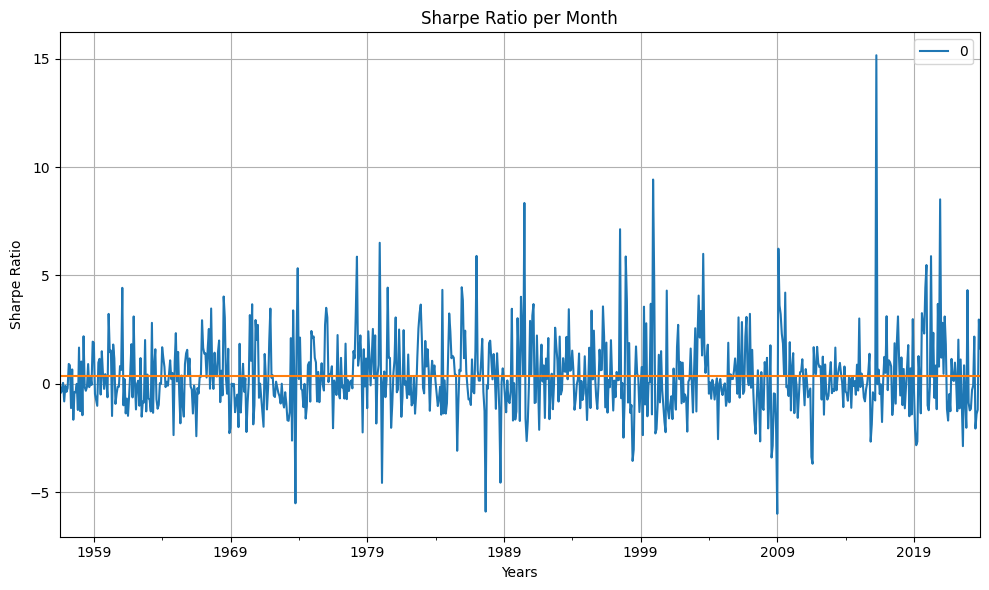

In [102]:
# Plot the sharpe ratio for each month
ax = plt.subplot()

sharpes = pd.DataFrame(sharpe_ratios, index=dates_with_data)
sharpes.plot(figsize=(10,6), ax=ax)
ax.set_xlabel("Years")
ax.set_ylabel("Sharpe Ratio")
ax.set_title("Sharpe Ratio per Month")
ax.grid()

ax.plot(sharpes.index, [np.mean(sharpes)] * len(sharpes.index))

plt.tight_layout()
plt.show()

In [103]:
np.mean(sharpes)

0.3704352205653008

3001317185.7741933


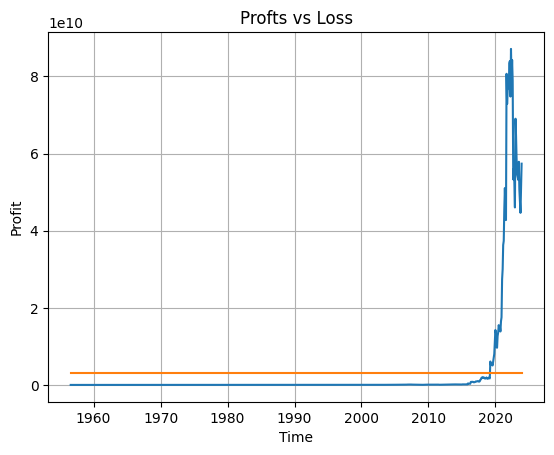

In [116]:
# Permno 72040.0   at 1991-11-30 is messing up
plt.plot(dates_with_data,pnl_curves)
plt.grid()
plt.title("Profts vs Loss")
plt.xlabel("Time")
plt.ylabel("Profit")
plt.plot(dates_with_data, [np.mean(pnl_curves)] * len(dates_with_data))
print(np.mean(pnl_curves))

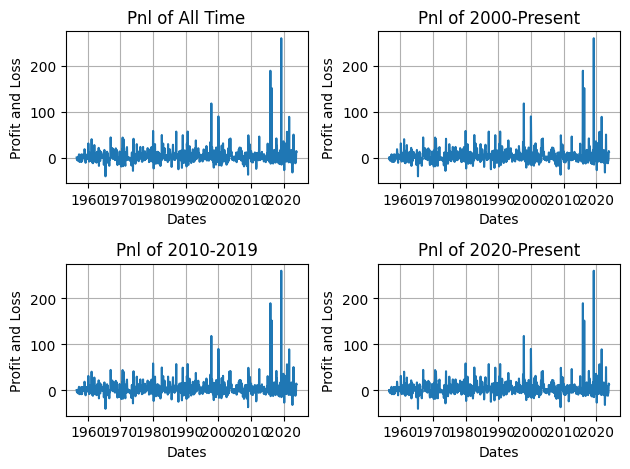

In [108]:
#This plots the Pnl over 4 time periods (all time, 2000-present, 2010-2019, 2020-present)
fig, axs = plt.subplots(2, 2)
# y0, y1 = 1e-12,5e-1

axs[0,0].set_title('Pnl of All Time') 
axs[0,0].plot(dates_with_data, pnl_curves)
axs[0,0].grid()

axs[0,1].set_title('Pnl of 2000-Present') 
axs[0,1].plot(dates_with_data, pnl_curves)
axs[0,1].grid()

axs[1,0].set_title('Pnl of 2010-2019') 
axs[1,0].plot(dates_with_data, pnl_curves)
axs[1,0].grid()

axs[1,1].set_title('Pnl of 2020-Present') 
axs[1,1].plot(dates_with_data, pnl_curves)
axs[1,1].grid()


for ax in axs.flat:
    ax.set(xlabel='Dates', ylabel='Profit and Loss')
fig.tight_layout()
plt.show()